In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models, optimizers, losses
import datetime as dt
import pymannkendall as mk
from properscoring import crps_ensemble
from dtaidistance import dtw
from statsmodels.tsa.stattools import acf

from pathlib import Path

C:\Users\mvana\.conda\envs\MSc\Lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


In [ ]:
# Current working directory (notebook folder)
notebook_path = Path.cwd()  # MLT/code/data_processing/
base_path = notebook_path.parent.parent  # Go up to MLT/

functions_path = notebook_path.parent / "000_Functions.ipynb"
data_path = base_path / "data" / "raw"
bronze_path = base_path / "data" / "bronze"
plots_path = base_path / "plots"

In [3]:
# Load custom functions
%run "{functions_path.as_posix()}"

In [4]:
# Load CSVs
df = pd.read_csv( bronze_path / "bronze_saber_1d_tempoaral_agg.csv")

In [5]:
date_time = pd.to_datetime(df['year_month']).dt.to_period('M')
df = df.sort_values(['year_month'])
df = df.dropna()

In [6]:
# Separate out year_month (non-numeric)
year_month = df['year_month']
# Keep only numeric columns for scaling
timeseries = df.drop(columns=['year_month'])
# fill missing
timeseries = timeseries.interpolate().dropna(axis=1)

In [7]:
# Create a numeric time index for slope computation
df['time_index'] = np.arange(len(df))

In [8]:
# Scaling
scaler = MinMaxScaler()
timeseries_scaled = scaler.fit_transform(timeseries.to_numpy().reshape(-1, 1)).flatten()

In [9]:
result = mk.original_test(timeseries['ktemp'])
result_scaled = mk.original_test(timeseries_scaled)

# Extract Sen's slope and intercept
slope = float(result.slope)
intercept = float(result.intercept)

slope_scaled = float(result_scaled.slope)
intercept_scaled = float(result_scaled.intercept)

# Compute Sen's trend line
df['sen_trend'] = intercept + slope * df['time_index']

In [10]:
n = len(timeseries)

In [11]:
# Windowing
SEQ_LEN = 24
PRED_LEN = 24

X, y = [], []
for i in range(n - SEQ_LEN - PRED_LEN):
    X.append(timeseries_scaled[i:i+SEQ_LEN])
    y.append(timeseries_scaled[i+SEQ_LEN:i+SEQ_LEN+PRED_LEN])
    
X = np.array(X)
y = np.array(y) 

# Train-test split (80-20 split)
split_idx = int(len(X) * 0.8)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

X_train = X_train.reshape(-1, SEQ_LEN)
X_test = X_test.reshape(-1, SEQ_LEN)

In [12]:
print("X shape:", X_train.shape)  # (batch, SEQ_LEN)
print("y shape:", X_test.shape)  # (batch, PRED_LEN)

X shape: (188, 24)
y shape: (47, 24)


In [13]:
# From numpy arrays
dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))

# Add batching
BATCH_SIZE = 32
dataset = dataset.batch(BATCH_SIZE)

for X_batch, y_batch in dataset.take(1):
    print("X shape:", X_batch.shape)  # (batch, SEQ_LEN)
    print("y shape:", y_batch.shape)  # (batch, PRED_LEN)

X shape: (32, 24)
y shape: (32, 24)


In [14]:
# Model
def build_model(seq_len, pred_len):
    inputs = layers.Input(shape=(seq_len, 1))
    x = layers.LSTM(64, return_sequences=False, activation='relu')(inputs)
    x = layers.Dense(32, activation='relu')(x)
    outputs = layers.Dense(pred_len)(x)
    model = models.Model(inputs=inputs, outputs = outputs)
    loss_fn = combined_loss_fn(a=slope, b=intercept_scaled, lambda_mse=1.0, lambda_ode=0.5)
    model.compile(optimizer='adam', loss=loss_fn, metrics=['mae', 'mse'])

    return model

model = build_model(SEQ_LEN, PRED_LEN)

In [15]:
history = model.fit(X_train, y_train, epochs=500, batch_size=16, verbose=0, validation_data=(X_test, y_test))

In [16]:
print(history.history.keys())

dict_keys(['loss', 'mae', 'mse', 'val_loss', 'val_mae', 'val_mse'])


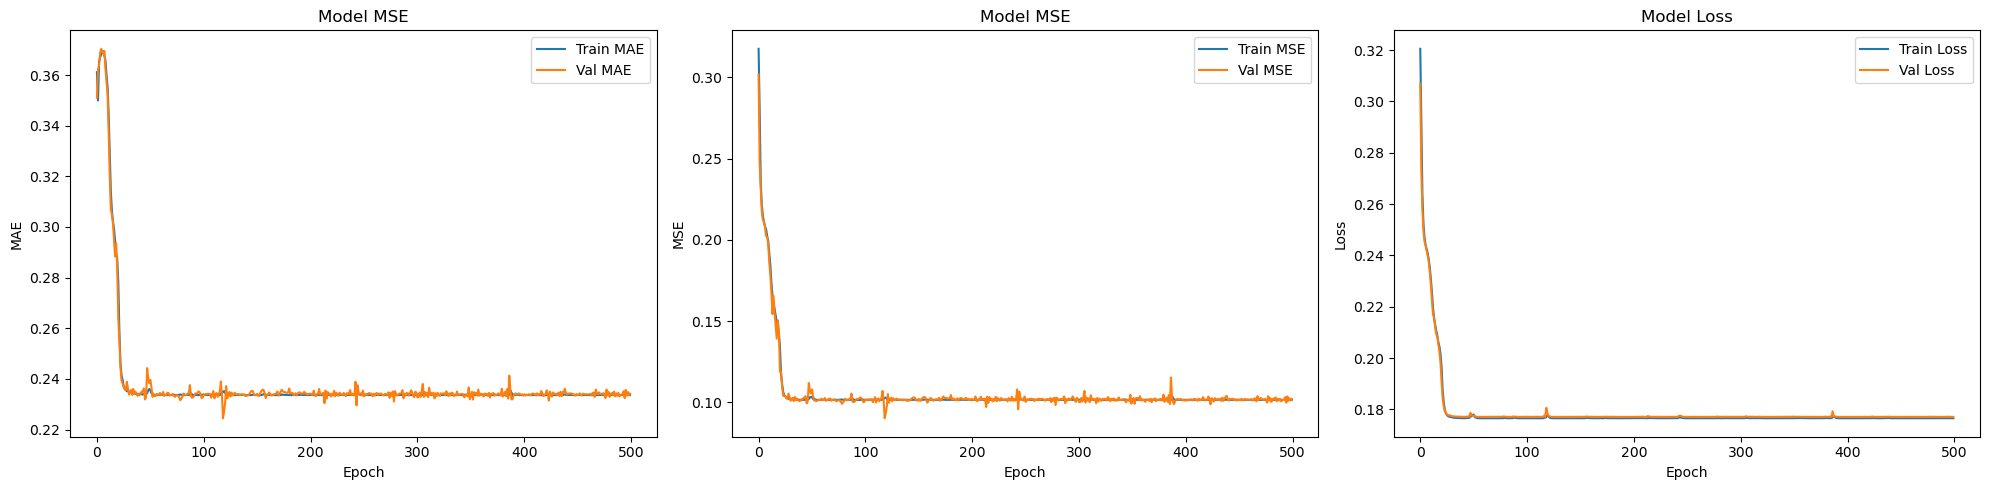

In [17]:
# Plotting accuracy
plt.figure(figsize=(20, 5))

plt.subplot(1, 3, 1)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.title('Model MSE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(history.history['mse'], label='Train MSE')
plt.plot(history.history['val_mse'], label='Val MSE')
plt.title('Model MSE')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()

# Plotting loss
plt.subplot(1, 3, 3)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [35]:
# Get the last sequence from your dataset
last_input = timeseries_scaled[-SEQ_LEN:]
# Reshape to match model input shape
last_input = last_input.reshape(1, SEQ_LEN, 1)
# Predict
forecast_scaled = model.predict(last_input)
# Unscale forecast
forecast_unscaled_raw = scaler.inverse_transform(forecast_scaled.reshape(-1, 1)).flatten()
# Shift forecast: timeseries[-1] becomes forecast_unscaled[0], forecast_unscaled_raw[0] becomes [1], etc.
forecast_unscaled = np.concatenate([timeseries.values[-1], forecast_unscaled_raw[:-1]])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


In [36]:
forecast_unscaled.shape

(26,)

In [ ]:
# Set parameters
start_date = np.datetime64("2002-01", 'M')

date_index = np.arange(start_date, start_date + n, dtype='datetime64[M]')

# Create forecast dates: PRED_LEN months after last original date
PRED_LEN = 24  # or your actual prediction length
forecast_start = date_index[-1]# + 1
forecast_dates = np.arange(forecast_start, forecast_start + PRED_LEN, dtype='datetime64[M]')

# Combine full time range for xticks
full_time_range = np.concatenate([date_index, forecast_dates])
tick_locs = np.arange(date_index[0], full_time_range[-1] + 1, 6, dtype='datetime64[M]')

# Compute the trend line equation string
slope = result.slope
intercept = result.intercept
equation_text = f"Linear Trend: y ={slope:.4f}*t +  {intercept:.2f}"

In [25]:
SEQ_LEN

24

In [32]:
forecast_unscaled.shape

(26,)

In [28]:
len(last_input)

1

In [30]:
last_input.shape

(1, 24, 1)

In [26]:
len(forecast_dates)

24

In [27]:
len(forecast_unscaled)

26

ValueError: x and y must have same first dimension, but have shapes (24,) and (26,)

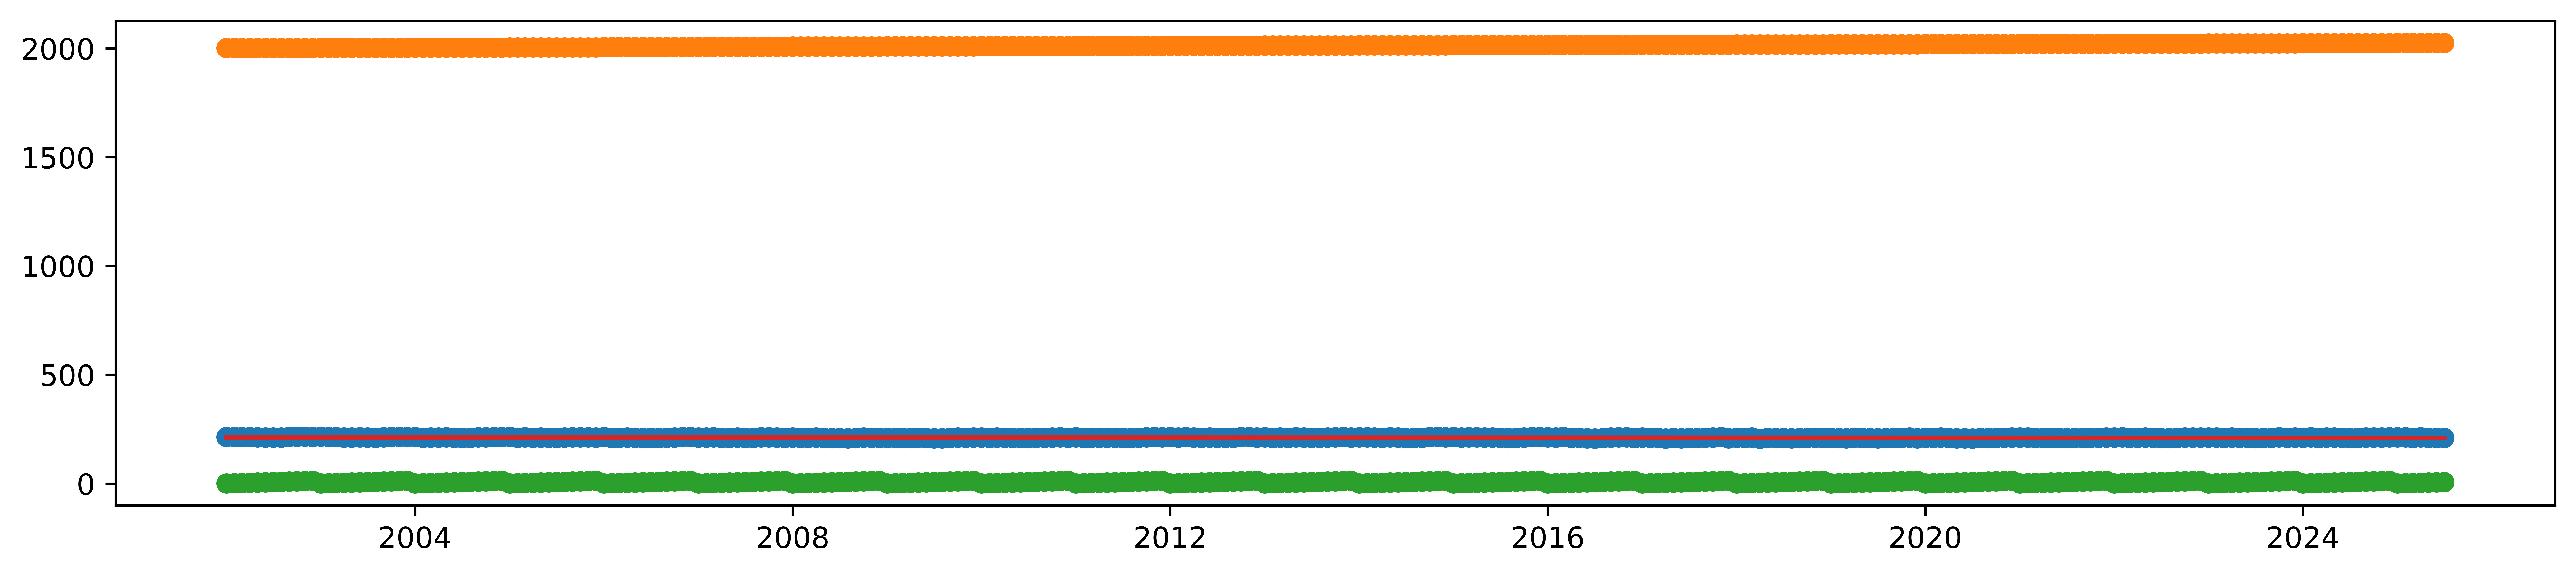

In [19]:
# Plot
plt.figure(figsize=(15, 3))
plt.plot(date_index, timeseries, marker='o', label="Original")
plt.plot(date_index, df['sen_trend'], label="Sen's Slope Trend")
plt.plot(forecast_dates, forecast_unscaled, label="Forecast", color="red")
# plt.fill_between(forecast_dates, lower_bound, upper_bound, color='red', alpha=0.2, label="95% CI")
plt.axvline(date_index[-1], color='gray', linestyle='--', linewidth=1)
plt.xticks(tick_locs, rotation=45)

# Add the equation text
plt.text(
    x=date_index[len(date_index) // 3],  # adjust index for placement
    y=max(df['ktemp']) - 0.5,     # adjust y-position as needed
    s=equation_text,
    fontsize=12,
    color='darkred',
    bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray')
)

plt.legend()
# plt.title("Physics-Informed LSTM Forecast")
plt.xlabel("Date")
plt.ylabel("ktemp")
plt.grid(True)
plt.tight_layout()
plt.savefig(plots_path / "Time_Series_Forecast.png", format='png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error
y_pred = model.predict(X_test.reshape(-1, SEQ_LEN, 1))
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Test RMSE: {rmse}")

In [ ]:
print("MAE:", mean_absolute_error(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))
print("RMSE:", root_mean_squared_error(y_test, y_pred))
print("MAPE:", mean_absolute_percentage_error(y_test, y_pred))
print("sMAPE:", symmetric_mape(y_test, y_pred))
print("MASE:", mean_absolute_scaled_error(y_test, y_pred))
print("Quantile loss:", quantile_loss(y_test, y_pred, quantile=0.9))

In [ ]:
print("DTW:", dtw_distance(y_test[0], y_pred[0]))
print("Pinball (q=0.9):", pinball_loss(y_test, y_pred, 0.9))
print("FSS (vs. naive):", forecast_skill_score(np.mean((y_test - y_pred)**2), 1.0))
print("NSE:", nash_sutcliffe_efficiency(y_test, y_pred))

In [ ]:
# Naive baseline
baseline_pred = np.tile(X_test[:, -1].reshape(-1, 1), (1, PRED_LEN))  # last observed value repeated

# Evaluate
evaluate_forecast(y_test, y_pred, baseline_pred=baseline_pred, title="LSTM Prediction")